# This notebook serves as the validation fo the correct implementation of the loss functions and their derivatives in CrysX-NN

# Plus, as a benchmark of the speed

## Run the following for Google colab 
then restart runtime

In [1]:
! pip install --upgrade --no-cache-dir https://github.com/manassharma07/crysx_nn/tarball/main
! pip install IPython==7.7.0

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # Ensure that evertyhing is only using CPU¶

import numpy as np
np.show_config()
import matplotlib.pyplot as plt

# Import activation functions from crysx_nn
from crysx_nn.loss import MSE_loss, MSE_loss_grad
from crysx_nn.loss import MAE_loss, MAE_loss_grad
from crysx_nn.loss import BCE_loss, BCE_loss_grad
from crysx_nn.loss import CCE_loss, CCE_loss_grad
import crysx_nn
print('CrysX-NN',crysx_nn.__version__)

# PyTorch
import torch
print('torch',torch.__version__)

# Tensorflow
import tensorflow as tf
print('tensorflow',tf.__version__)

blas_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
blas_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
lapack_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
lapack_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = [

## Ensure that evertyhing is only using CPU

In [2]:
torch.cuda.is_available()

False

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [10]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [11]:
print(tf.test.is_built_with_cuda())

True


## Generate an input `2d array` of type `float32` for benchmark (let's say using `torch`)

In [6]:
predictions_torch = 100*torch.rand((300,100),requires_grad=True)
print(predictions_torch)
targets_torch = 100*torch.rand((300,100),requires_grad=True)
print(targets_torch)

tensor([[7.8325e+01, 7.1665e+01, 2.2816e+01,  ..., 3.7080e+01, 7.5645e+01,
         8.4311e+01],
        [6.0137e+01, 7.2536e+01, 8.0802e+01,  ..., 3.1254e+01, 9.2218e+01,
         6.5933e+01],
        [1.4337e+01, 5.7792e+01, 6.8158e+01,  ..., 8.3601e+00, 6.9265e+01,
         8.8062e+01],
        ...,
        [1.5256e+01, 3.2807e+01, 8.5318e-02,  ..., 9.7137e+01, 7.7739e+01,
         7.4735e+01],
        [6.0158e+00, 5.8915e+01, 3.2583e+01,  ..., 6.8470e+01, 8.4217e+00,
         9.1502e+01],
        [9.4338e+01, 1.6464e+01, 4.4108e+01,  ..., 7.4684e+01, 3.1274e+01,
         4.1247e+00]], grad_fn=<MulBackward0>)
tensor([[ 9.0868, 34.9519, 34.9496,  ..., 40.7303,  6.9180,  4.4952],
        [40.6986, 56.5676, 45.2916,  ..., 77.8941, 51.2611, 19.5253],
        [36.1892, 14.3350, 88.4473,  ..., 42.1479, 59.8267, 17.1892],
        ...,
        [47.4327, 94.0944, 57.9000,  ..., 78.6854, 21.6182,  5.1914],
        [68.0604, 25.3448, 96.9070,  ..., 97.4925, 38.3283, 88.3539],
        [ 7.9165,

## Convert it to numpy for `crysx_nn`

In [7]:
predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
print(predictions_crysx_nn.dtype)
targets_crysx_nn = targets_torch.cpu().detach().numpy()
print(targets_crysx_nn.dtype)

float32
float32


## Now finally convert it to a tensorflow tensor

In [8]:
predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)

## Benchmark MSE_loss

### Confirm that all frameworks give the same results

PyTorch expects predictions first then targets

PyTorch - https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html

TensorFlow expects targets first then predictions

Tensorflow - https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError

CrysX-NN doesn't return values averaged over samples. So take care of that.

In [9]:
# Torch
mse_loss_func = torch.nn.MSELoss()
mse_torch_value = mse_loss_func(predictions_torch, targets_torch)

# CrysX
mse_crysx_nn_value = MSE_loss(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
print(type(mse_crysx_nn_value))

# Tensorflow
mse_tf_func = tf.keras.losses.MeanSquaredError()
mse_tf_value = mse_tf_func(targets_tf, predictions_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(mse_torch_value.cpu().detach().numpy() - mse_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(mse_torch_value.cpu().detach().numpy() - mse_crysx_nn_value).max())

<class 'float'>
Max abs diff b/w torch and tf 0.00012207031
Max abs diff b/w torch and CrysX 8.392161203119031e-05


### Compare performance with arrays of different sizes

In [10]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,3000,500):
    sizes.append(n_size*n_size)
    # Torch input
    predictions_torch = 100*torch.rand((n_size,n_size),requires_grad=True)
    targets_torch = 100*torch.rand((n_size,n_size),requires_grad=True)
    # CrysX-NN input
    predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
    targets_crysx_nn = targets_torch.cpu().detach().numpy()
    # Tensorflow input
    predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
    targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    mse_loss_func = torch.nn.MSELoss()
    mse_torch_value = mse_loss_func(predictions_torch, targets_torch)
    time = %timeit -n 500 -o mse_loss_func(predictions_torch, targets_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    mse_crysx_nn_value = MSE_loss(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
    time = %timeit -n 500 -o MSE_loss(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    mse_tf_func = tf.keras.losses.MeanSquaredError()
    mse_tf_value = mse_tf_func(targets_tf, predictions_tf)
    time = %timeit -n 500 -o mse_tf_func(targets_tf, predictions_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))
    print('Size:', predictions_crysx_nn.shape)
    #Diff b/w tf and torch
    print('Max abs diff b/w torch and tf', abs(mse_torch_value.cpu().detach().numpy() - mse_tf_value.numpy()).max())
    #Diff b/w crysx_nn and torch
    print('Max abs diff b/w torch and CrysX', abs(mse_torch_value.cpu().detach().numpy() - mse_crysx_nn_value).max())

18.4 µs ± 535 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
6.95 µs ± 402 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
155 µs ± 20.4 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
Size: (10, 10)
Max abs diff b/w torch and tf 0.00012207031
Max abs diff b/w torch and CrysX 0.00011098352251792676
64.5 µs ± 3.6 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
78 µs ± 9.95 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
305 µs ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
Size: (510, 510)
Max abs diff b/w torch and tf 0.0
Max abs diff b/w torch and CrysX 6.1520047211161e-05
730 µs ± 58.7 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
211 µs ± 36.1 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
1.09 ms ± 26.8 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
Size: (1010, 1010)
Max abs diff b/w torch and tf 0.00024414062
Max abs diff b/w torch and CrysX 7.428284948218788e-05
2.22 ms ± 580 µs per loo

### Plot the results

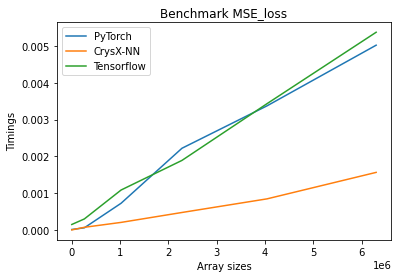

In [11]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Timings')
plt.title('Benchmark MSE_loss')
plt.show()

### Validate gradients

In [21]:
def tf_mse_grad(targets_tf, predictions_tf):
    with tf.GradientTape() as g:
        g.watch(predictions_tf)
        mse_tf_func = tf.keras.losses.MeanSquaredError()
        mse_tf_value = mse_tf_func(targets_tf, predictions_tf)
    grad = g.gradient(mse_tf_value, predictions_tf)
    return grad#.numpy()

In [22]:
# Torch input
predictions_torch = 10000*torch.rand((2000,3000),requires_grad=True)
targets_torch = 10000*torch.rand((2000,3000),requires_grad=True)
# CrysX-NN input
predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
targets_crysx_nn = targets_torch.cpu().detach().numpy()
# Tensorflow input
predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)

# Torch
mse_loss_func = torch.nn.MSELoss()
mse_torch_value = mse_loss_func(predictions_torch, targets_torch)
mse_torch_value.backward()
gradientTorch = torch.autograd.grad(mse_loss_func(predictions_torch,targets_torch),predictions_torch)[0]
# print(gradientTorch)

# CrysX
gradientCrysX_NN = MSE_loss_grad(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]

# Tensorflow
gradientTF = tf_mse_grad(targets_tf, predictions_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientTorch.cpu().detach().numpy() - gradientTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientTorch.cpu().detach().numpy() - gradientCrysX_NN).max())

Max abs diff b/w torch and tf 4.656613e-10
Max abs diff b/w torch and CrysX 2.3283064e-10


## Benchmark BCE_loss

### Confirm that all frameworks give the same results

PyTorch expects predictions first then targets

PyTorch - https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html

TensorFlow expects targets first then predictions

Tensorflow - https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy

CrysX-NN doesn't return values averaged over samples. So take care of that.

In [14]:
# Torch input
predictions_torch = torch.rand((2000,3000),requires_grad=True)
# print(predictions_torch)
targets_torch = torch.randint(low=0,high=2, size=(2000,3000)).float()
# print(targets_torch)
# CrysX-NN input
predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
targets_crysx_nn = targets_torch.cpu().detach().numpy()
# Tensorflow input
predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)

# Torch
bce_loss_func = torch.nn.BCELoss()
bce_torch_value = bce_loss_func(predictions_torch, targets_torch)

# CrysX
bce_crysx_nn_value = BCE_loss(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
# print(bce_crysx_nn_value)

# Tensorflow
bce_tf_func = tf.keras.losses.BinaryCrossentropy()
bce_tf_value = bce_tf_func(targets_tf, predictions_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(bce_torch_value.cpu().detach().numpy() - bce_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(bce_torch_value.cpu().detach().numpy() - bce_crysx_nn_value).max())

Max abs diff b/w torch and tf 1.66893e-06
Max abs diff b/w torch and CrysX 7.136674584629077e-09


### Compare performance with arrays of different sizes

In [15]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,3000,500):
    sizes.append(n_size*n_size)
    # Torch input
    predictions_torch = torch.rand((n_size,n_size),requires_grad=True)
    targets_torch = torch.randint(low=0,high=2, size=(n_size,n_size)).float()
    # CrysX-NN input
    predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
    targets_crysx_nn = targets_torch.cpu().detach().numpy()
    # Tensorflow input
    predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
    targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    bce_loss_func = torch.nn.BCELoss()
    bce_torch_value = bce_loss_func(predictions_torch, targets_torch)
    time = %timeit -n 100 -o bce_loss_func(predictions_torch, targets_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    bce_crysx_nn_value = BCE_loss(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
    time = %timeit -n 100 -o BCE_loss(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    bce_tf_func = tf.keras.losses.BinaryCrossentropy()
    bce_tf_value = bce_tf_func(targets_tf, predictions_tf)
    time = %timeit -n 100 -o bce_tf_func(targets_tf, predictions_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))
    print('Size:', predictions_crysx_nn.shape)
    #Diff b/w tf and torch
    print('Max abs diff b/w torch and tf', abs(bce_torch_value.cpu().detach().numpy() - bce_tf_value.numpy()).max())
    #Diff b/w crysx_nn and torch
    print('Max abs diff b/w torch and CrysX', abs(bce_torch_value.cpu().detach().numpy() - bce_crysx_nn_value).max())

22.1 µs ± 1.63 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.4 µs ± 1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
351 µs ± 46.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Size: (10, 10)
Max abs diff b/w torch and tf 4.7683716e-07
Max abs diff b/w torch and CrysX 2.2624234041757063e-08
781 µs ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
872 µs ± 41 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.07 ms ± 9.44 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Size: (510, 510)
Max abs diff b/w torch and tf 1.1920929e-06
Max abs diff b/w torch and CrysX 9.434801673258164e-08
3.37 ms ± 30.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.83 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.3 ms ± 2.22 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Size: (1010, 1010)
Max abs diff b/w torch and tf 1.4305115e-06
Max abs diff b/w torch and CrysX 1.5482200632632726e-08
8.29 ms ± 6

### Plot the results

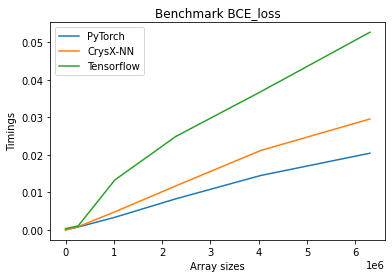

In [16]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Timings')
plt.title('Benchmark BCE_loss')
plt.show()

### Validate gradients

In [9]:
def tf_bce_grad(targets_tf, predictions_tf):
    with tf.GradientTape() as g:
        g.watch(predictions_tf)
        bce_tf_func = tf.keras.losses.BinaryCrossentropy()
        bce_tf_value = bce_tf_func(targets_tf, predictions_tf)
    grad = g.gradient(bce_tf_value, predictions_tf)
    return grad#.numpy()

In [10]:
nSamples = 2000
nOutputs = 3000#nClasess
# Torch input
predictions_torch_ = torch.rand((nSamples,nOutputs),requires_grad=True)
# print(predictions_torch)
# Predictions are supposed to be probabilities from 0 to 1, summing upto 1.
# Therefore, apply a softmax on them
m = torch.nn.Softmax()
predictions_torch = m(predictions_torch_)
# print(predictions_torch)
# Generate random one hot vectors matrix
# No. of classes
n = nOutputs
target_indices = torch.randint(1,n, size=(1,nSamples)).reshape(nSamples) # Get a 1D tensor index of size =nSamples=2000
# print(target_indices)
# print(target_indices.shape)
# Convert the index tensor to one-hot encoded vectors matrix
target_one_hot = torch.nn.functional.one_hot(target_indices, n) # size=(4,7,n)
targets_torch = target_one_hot.float() # torch.randint(low=0,high=2, size=(2000,3000)).float()
# print(targets_torch)
# print(targets_torch.shape)
# CrysX-NN input
predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
targets_crysx_nn = targets_torch.cpu().detach().numpy()
# Tensorflow input
predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)

# Torch
bce_loss_func = torch.nn.BCELoss()
bce_torch_value = bce_loss_func(predictions_torch, targets_torch)
bce_torch_value.backward()
gradientTorch = torch.autograd.grad(bce_loss_func(predictions_torch,targets_torch),predictions_torch)[0]
# print(gradientTorch)

# CrysX
gradientCrysX_NN = BCE_loss_grad(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]

# Tensorflow
gradientTF = tf_bce_grad(targets_tf, predictions_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientTorch.cpu().detach().numpy() - gradientTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientTorch.cpu().detach().numpy() - gradientCrysX_NN).max())

C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


Max abs diff b/w torch and tf 4.490139e-07
Max abs diff b/w torch and CrysX 1.1641532e-10


## Benchmark MAE_loss

### Confirm that all frameworks give the same results

PyTorch expects predictions first then targets

PyTorch - https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html

TensorFlow expects targets first then predictions

Tensorflow - https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanAbsoluteError

CrysX-NN doesn't return values averaged over samples. So take care of that.

In [10]:
# Torch
predictions_torch = 100*torch.rand((300,100),requires_grad=True)
targets_torch = 100*torch.rand((300,100),requires_grad=True)
# CrysX
predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
targets_crysx_nn = targets_torch.cpu().detach().numpy()
# TensorFlow
predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)

# Torch
mae_loss_func = torch.nn.L1Loss()
mae_torch_value = mae_loss_func(predictions_torch, targets_torch)

# CrysX
mae_crysx_nn_value = MAE_loss(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
print(type(mae_crysx_nn_value))

# Tensorflow
mae_tf_func = tf.keras.losses.MeanAbsoluteError()
mae_tf_value = mae_tf_func(targets_tf, predictions_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(mae_torch_value.cpu().detach().numpy() - mae_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(mae_torch_value.cpu().detach().numpy() - mae_crysx_nn_value).max())

<class 'float'>
Max abs diff b/w torch and tf 0.0
Max abs diff b/w torch and CrysX 9.93617376821021e-07


### Compare performance with arrays of different sizes

In [12]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,3000,500):
    sizes.append(n_size*n_size)
    # Torch input
    predictions_torch = 100*torch.rand((n_size,n_size),requires_grad=True)
    targets_torch = 100*torch.rand((n_size,n_size),requires_grad=True)
    # CrysX-NN input
    predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
    targets_crysx_nn = targets_torch.cpu().detach().numpy()
    # Tensorflow input
    predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
    targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    mae_loss_func = torch.nn.L1Loss()
    mae_torch_value = mae_loss_func(predictions_torch, targets_torch)
    time = %timeit -n 300 -o mae_loss_func(predictions_torch, targets_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    mae_crysx_nn_value = MAE_loss(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
    time = %timeit -n 300 -o MAE_loss(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    mae_tf_func = tf.keras.losses.MeanAbsoluteError()
    mae_tf_value = mae_tf_func(targets_tf, predictions_tf)
    time = %timeit -n 300 -o mae_tf_func(targets_tf, predictions_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))
    print('Size:', predictions_crysx_nn.shape)
    #Diff b/w tf and torch
    print('Max abs diff b/w torch and tf', abs(mae_torch_value.cpu().detach().numpy() - mae_tf_value.numpy()).max())
    #Diff b/w crysx_nn and torch
    print('Max abs diff b/w torch and CrysX', abs(mae_torch_value.cpu().detach().numpy() - mae_crysx_nn_value).max())

21.7 µs ± 1.93 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
10.7 µs ± 312 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
198 µs ± 8.02 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
Size: (10, 10)
Max abs diff b/w torch and tf 3.8146973e-06
Max abs diff b/w torch and CrysX 2.3460388192120263e-06
171 µs ± 6.41 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
49.6 µs ± 1.71 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
457 µs ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
Size: (510, 510)
Max abs diff b/w torch and tf 3.8146973e-06
Max abs diff b/w torch and CrysX 4.631623262696394e-06
1.1 ms ± 72.3 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
146 µs ± 3.13 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
2.17 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
Size: (1010, 1010)
Max abs diff b/w torch and tf 3.8146973e-06
Max abs diff b/w torch and CrysX 1.5040935608112704e-06
2.75 ms ±

### Plot the results

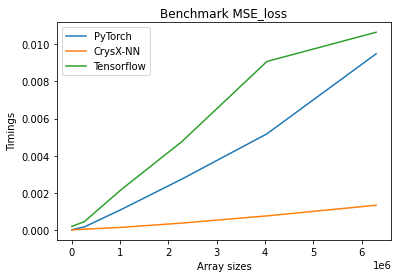

In [13]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Timings')
plt.title('Benchmark MAE_loss')
plt.show()

### Validate gradients

In [2]:
def tf_mae_grad(targets_tf, predictions_tf):
    with tf.GradientTape() as g:
        g.watch(predictions_tf)
        mae_tf_func = tf.keras.losses.MeanAbsoluteError()
        mae_tf_value = mae_tf_func(targets_tf, predictions_tf)
    grad = g.gradient(mae_tf_value, predictions_tf)
    return grad#.numpy()

In [5]:
# Torch input
predictions_torch = 10000*torch.rand((2000,3000),requires_grad=True)
targets_torch = 10000*torch.rand((2000,3000),requires_grad=True)
# CrysX-NN input
predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
targets_crysx_nn = targets_torch.cpu().detach().numpy()
# Tensorflow input
predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)

# Torch
mae_loss_func = torch.nn.L1Loss()
mae_torch_value = mae_loss_func(predictions_torch, targets_torch)
mae_torch_value.backward()
gradientTorch = torch.autograd.grad(mae_loss_func(predictions_torch,targets_torch),predictions_torch)[0]
# print(gradientTorch)

# CrysX
gradientCrysX_NN = MAE_loss_grad(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
# print(gradientCrysX_NN)


# Tensorflow
gradientTF = tf_mae_grad(targets_tf, predictions_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientTorch.cpu().detach().numpy() - gradientTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientTorch.cpu().detach().numpy() - gradientCrysX_NN).max())

Max abs diff b/w torch and tf 1.4210855e-14
Max abs diff b/w torch and CrysX 4.2079286565503357e-16


## Benchmark CCE_loss

### Confirm that all frameworks give the same results

PyTorch expects predictions first then targets

PyTorch - https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

TensorFlow expects targets first then predictions

Tensorflow - https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy

CrysX-NN doesn't return values averaged over samples. So take care of that.

<b>Note:</b> TensorFlow and CrysX-NN expect one-hot encoded vectors.
<b>Note:</b> Unfortunately, PyTorch computes the Cross Entropy in a weird fashion. It expects the inputs to not be probabilities. Rather it computes the probabilities from the inputs using the Softmax function and then returns the Cross Entropy Loss.https://stackoverflow.com/questions/49390842/cross-entropy-in-pytorch

Unrelated but useful info some of the answers and comments for future reference: https://stackoverflow.com/questions/42081257/why-binary-crossentropy-and-categorical-crossentropy-give-different-performances

In [7]:
nSamples = 2000
nOutputs = 3000#nClasess
# Torch input
predictions_torch_ = torch.rand((nSamples,nOutputs),requires_grad=True)
# print(predictions_torch)
# Predictions are supposed to be probabilities from 0 to 1, summing upto 1.
# Therefore, apply a softmax on them
m = torch.nn.Softmax()
predictions_torch = m(predictions_torch_)
# print(predictions_torch)
# Generate random one hot vectors matrix
# No. of classes
n = nOutputs
target_indices = torch.randint(1,n, size=(1,nSamples)).reshape(nSamples) # Get a 1D tensor index of size =nSamples=2000
# print(target_indices)
# print(target_indices.shape)
# Convert the index tensor to one-hot encoded vectors matrix
target_one_hot = torch.nn.functional.one_hot(target_indices, n) # size=(4,7,n)
targets_torch = target_one_hot.float() # torch.randint(low=0,high=2, size=(2000,3000)).float()
# print(targets_torch)
# print(targets_torch.shape)
# CrysX-NN input
predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
targets_crysx_nn = targets_torch.cpu().detach().numpy()
# Tensorflow input
predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)

# Torch
cce_loss_func = torch.nn.CrossEntropyLoss()
# cce_loss_func = torch.nn.NLLLoss()
cce_torch_value = cce_loss_func(predictions_torch_, targets_torch)
# print(cce_torch_value)

# CrysX
cce_crysx_nn_value = CCE_loss(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
# print(cce_crysx_nn_value)

# Tensorflow
cce_tf_func = tf.keras.losses.CategoricalCrossentropy()
cce_tf_value = cce_tf_func(targets_tf, predictions_tf)
# print(cce_tf_value)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(cce_torch_value.cpu().detach().numpy() - cce_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(cce_torch_value.cpu().detach().numpy() - cce_crysx_nn_value).max())


tensor(8.0561, grad_fn=<DivBackward1>)
8.05609423828125
tf.Tensor(8.056095, shape=(), dtype=float32)
Max abs diff b/w torch and tf 9.536743e-07
Max abs diff b/w torch and CrysX 6.86645513781059e-08


C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


### Compare performance with arrays of different sizes

In [15]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,3000,500):
    sizes.append(n_size*n_size)
    # Torch input
    predictions_torch = torch.rand((n_size,n_size),requires_grad=True)
    targets_torch = torch.randint(low=0,high=2, size=(n_size,n_size)).float()
    # CrysX-NN input
    predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
    targets_crysx_nn = targets_torch.cpu().detach().numpy()
    # Tensorflow input
    predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
    targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    bce_loss_func = torch.nn.BCELoss()
    bce_torch_value = bce_loss_func(predictions_torch, targets_torch)
    time = %timeit -n 100 -o bce_loss_func(predictions_torch, targets_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    bce_crysx_nn_value = BCE_loss(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
    time = %timeit -n 100 -o BCE_loss(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    bce_tf_func = tf.keras.losses.BinaryCrossentropy()
    bce_tf_value = bce_tf_func(targets_tf, predictions_tf)
    time = %timeit -n 100 -o bce_tf_func(targets_tf, predictions_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))
    print('Size:', predictions_crysx_nn.shape)
    #Diff b/w tf and torch
    print('Max abs diff b/w torch and tf', abs(bce_torch_value.cpu().detach().numpy() - bce_tf_value.numpy()).max())
    #Diff b/w crysx_nn and torch
    print('Max abs diff b/w torch and CrysX', abs(bce_torch_value.cpu().detach().numpy() - bce_crysx_nn_value).max())

22.1 µs ± 1.63 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.4 µs ± 1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
351 µs ± 46.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Size: (10, 10)
Max abs diff b/w torch and tf 4.7683716e-07
Max abs diff b/w torch and CrysX 2.2624234041757063e-08
781 µs ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
872 µs ± 41 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.07 ms ± 9.44 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Size: (510, 510)
Max abs diff b/w torch and tf 1.1920929e-06
Max abs diff b/w torch and CrysX 9.434801673258164e-08
3.37 ms ± 30.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.83 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.3 ms ± 2.22 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Size: (1010, 1010)
Max abs diff b/w torch and tf 1.4305115e-06
Max abs diff b/w torch and CrysX 1.5482200632632726e-08
8.29 ms ± 6

### Plot the results

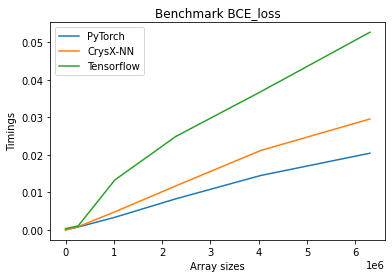

In [16]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Timings')
plt.title('Benchmark CCE_loss')
plt.show()

### Validate gradients

In [34]:
def tf_bce_grad(targets_tf, predictions_tf):
    with tf.GradientTape() as g:
        g.watch(predictions_tf)
        bce_tf_func = tf.keras.losses.BinaryCrossentropy()
        bce_tf_value = bce_tf_func(targets_tf, predictions_tf)
    grad = g.gradient(bce_tf_value, predictions_tf)
    return grad#.numpy()

In [35]:
# Torch input
predictions_torch = torch.rand((2000,3000),requires_grad=True)
# print(predictions_torch)
targets_torch = torch.randint(low=0,high=2, size=(2000,3000)).float()
# print(targets_torch)
# CrysX-NN input
predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
targets_crysx_nn = targets_torch.cpu().detach().numpy()
# Tensorflow input
predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)

# Torch
bce_loss_func = torch.nn.BCELoss()
bce_torch_value = bce_loss_func(predictions_torch, targets_torch)
bce_torch_value.backward()
gradientTorch = torch.autograd.grad(bce_loss_func(predictions_torch,targets_torch),predictions_torch)[0]
# print(gradientTorch)

# CrysX
gradientCrysX_NN = BCE_loss_grad(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]

# Tensorflow
gradientTF = tf_bce_grad(targets_tf, predictions_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientTorch.cpu().detach().numpy() - gradientTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientTorch.cpu().detach().numpy() - gradientCrysX_NN).max())

Max abs diff b/w torch and tf 2.7962027
Max abs diff b/w torch and CrysX 2.9802322e-08
